<a href="https://colab.research.google.com/github/DiwakarBasnet/GIF_recommender/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32      # Number of training samples to work through before model's internal parameters are upadted
IMAGE_SIZE = 48      # Size of image
CHANNELS = 3         # RGB channels
EPOCHS = 50          # Number of passes of the entire training dataset

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset from kaggle

In [4]:
! pip install -q kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
# allocate required permission for file
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d msambare/fer2013

 98% 59.0M/60.3M [00:00<00:00, 114MB/s]
100% 60.3M/60.3M [00:00<00:00, 104MB/s]


In [9]:
! unzip fer2013.zip &> /dev/null

# Train test split

In [10]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./train",                               # directory
    labels = "inferred",                     # labels are generated from directory structure
    label_mode = "int",                      # labels are encoded as integer
    batch_size = BATCH_SIZE,                 # size of batches data
    image_size = (IMAGE_SIZE, IMAGE_SIZE),   # size to resize images after they are read from disk
    shuffle = True,                          # if false, sorts the data in alphanumeric order
    seed = 123                               # random seed for shuffling and transformation    
)

Found 28709 files belonging to 7 classes.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test",
    labels = "inferred",
    label_mode = "int",
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
    seed = 123
)

Found 7178 files belonging to 7 classes.


In [12]:
ds_size = len(ds)
train_size = int(0.70 * ds_size)     # train = 0.70 part of ds
val_size = int(0.30 * ds_size)       # validation = 0.30 part of ds

In [13]:
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)

# Data Visualization

In [14]:
class_names = ds.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

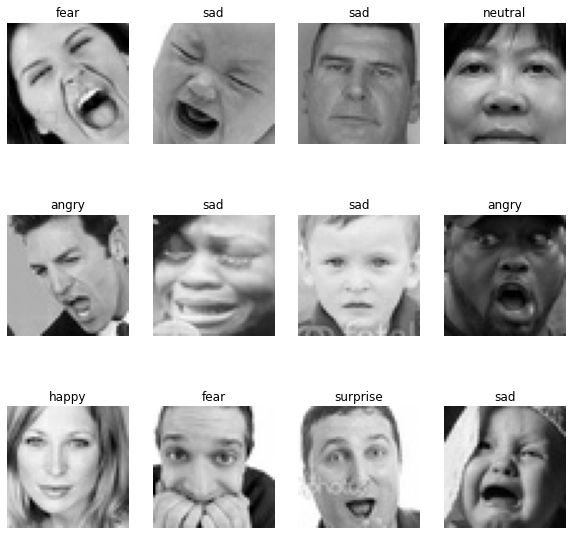

In [15]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in ds.take(1):             # takes 1 batch of tf_dataset
  for i in range(12):
    ax = plt.subplot(3,4,i+1)                           # r:3, c:4, id:i+1
    plt.imshow(image_batch[i].numpy().astype("uint8"))  # .numpy() = converts tensor to numpy array
                                                        # .astype("uint8") = converts float to int
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# Preprocessing

In [16]:
# tensorflow data input pipeline:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)   # .cache() = reads image from disk and puts it in memory
                                                                                     # when needed later, which improves performance of pipeline
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)       # .shuffle(1000) = shuffles 1000th tensor along dimension 0

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)     # .prefetch() = if GPU is busy trainig, it loads next set 
                                                                                     # batch from disk and improves performance

In [17]:
resize_and_rescale = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
          tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
# data_augmentation = tf.keras.Sequential([
#           tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#           tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
# ])

# Build and train model

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
            resize_and_rescale,
            #data_augmentation,

            # 1st convolution layer
            layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            layers.MaxPool2D((2,2)),
            layers.Dropout(0.5),

            # 2nd convolution layer
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPool2D((2,2)),
            layers.Dropout(0.5),

            # 3rd convolution layer
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.MaxPool2D((2,2)),

            layers.Flatten(),

            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(7, activation='softmax')
])

model.build(input_shape = input_shape)        # model.build is required by api

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 48, 48, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 46, 46, 64)          1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 23, 23, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 23, 23, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (32, 21, 21, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 10, 10, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),    # when labels in dataset is inferred use SparseCategoricalCrossentropy()
    metrics = ['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,                # 1 shows progress bar
    validation_data = val_ds,
    shuffle = True
)

# Saving the  model to  use it later on
fer_json = model.to_json()
with open("drive/MyDrive/Models/model.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("drive/MyDrive/Models/model.h5")

Epoch 1/50
628/628 [==============================] - 29s 23ms/step - loss: 1.7862 - accuracy: 0.2684 - val_loss: 1.7044 - val_accuracy: 0.3081
Epoch 2/50
628/628 [==============================] - 5s 8ms/step - loss: 1.6148 - accuracy: 0.3695 - val_loss: 1.5427 - val_accuracy: 0.4031
Epoch 3/50
628/628 [==============================] - 5s 8ms/step - loss: 1.5163 - accuracy: 0.4120 - val_loss: 1.4384 - val_accuracy: 0.4514
Epoch 4/50
628/628 [==============================] - 5s 8ms/step - loss: 1.4283 - accuracy: 0.4468 - val_loss: 1.3811 - val_accuracy: 0.4812
Epoch 5/50
628/628 [==============================] - 5s 8ms/step - loss: 1.3672 - accuracy: 0.4738 - val_loss: 1.3056 - val_accuracy: 0.4976
Epoch 6/50
628/628 [==============================] - 5s 8ms/step - loss: 1.3193 - accuracy: 0.4966 - val_loss: 1.2976 - val_accuracy: 0.5037
Epoch 7/50
628/628 [==============================] - 5s 8ms/step - loss: 1.2728 - accuracy: 0.5148 - val_loss: 1.2454 - val_accuracy: 0.5271
Epoc

In [23]:
scores = model.evaluate(test_ds)

225/225 [==============================] - 2s 4ms/step - loss: 2.1092 - accuracy: 0.5549


# Plot training history on graph

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

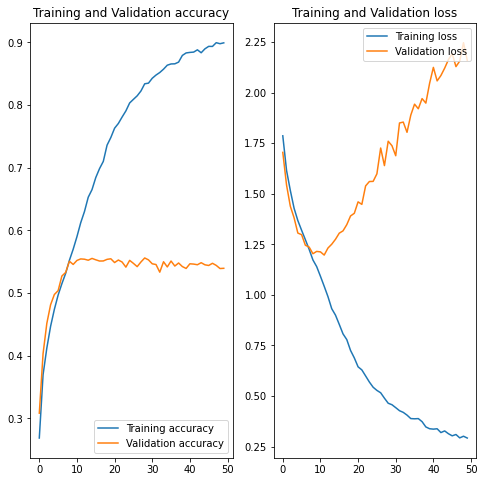

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show()

# Predictions on Sample images

In [26]:
# predict function takes model and image
def predict(model, img):
  #img_array = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))                    # resize the image (this line is for api) 
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())      # converts image to numpy array
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]                      # .argmax = returns index with highest argument
  confidence = round(100 * (np.max(predictions[0])), 2)                         # .max = returns highest argument

  return predicted_class, confidence

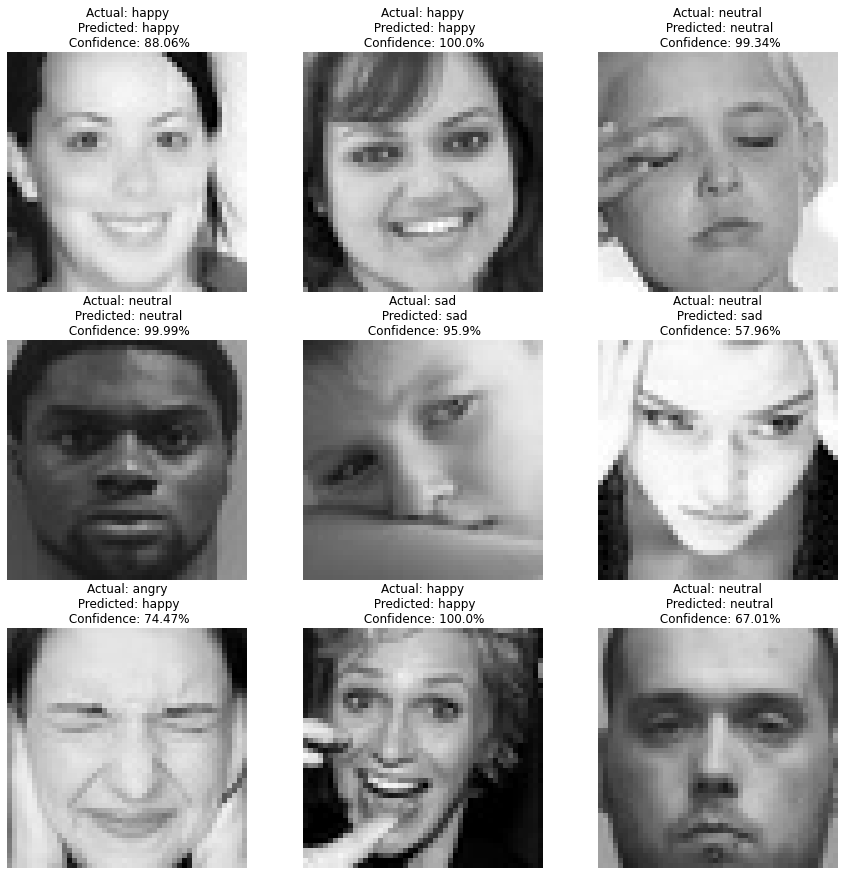

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
    plt.axis("off")

In [28]:
model_name = "emotion_recognizer"
model.save(f"./drive/MyDrive/Models/{model_name}")

INFO:tensorflow:Assets written to: ./drive/MyDrive/Models/emotion_recognizer/assets
